# Sample registration of an image to patterns

Since thre is still an deformation among input images and its representation we look for a descriptive transformations...

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import matplotlib.pylab as plt

from bpdl import data_utils as tl_data
import notebooks.notebook_utils as nb_utils

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Input images

In [2]:
# STATIC IMAGE - from atlas
img_static, img_moving = nb_utils.generate_synth_image_pair_simple()
img_static_fuzzy = tl_data.image_transform_binary2fuzzy(img_static, coef=0.2)
img_moving_fuzzy = tl_data.image_transform_binary2fuzzy(img_moving, coef=0.2)

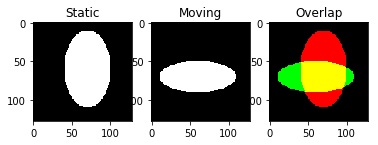

In [3]:
plt.subplot(1, 3, 1), plt.imshow(img_static, cmap=plt.cm.Greys_r), plt.title('Static')
plt.subplot(1, 3, 2), plt.imshow(img_moving, cmap=plt.cm.Greys_r), plt.title('Moving')
im_overlap = np.rollaxis(np.array([img_static, img_moving, np.zeros(img_static.shape)]), 0, 3)
_= plt.subplot(1, 3, 3), plt.imshow(im_overlap), plt.title('Overlap')

## Symmetric Diffeomorphic Registration

This [example](http://nipy.org/dipy/examples_built/syn_registration_2d.html#example-syn-registration-2d) explains how to register 2D images using the Symmetric Normalization (SyN) algorithm proposed by Avants et al. [Avants09](https://doi.org/10.1016/j.media.2007.06.004) (also implemented in the ANTS software [Avants11](http://scil.dinf.usherbrooke.ca/wp-content/courses/imn530/ants.pdf))

In [4]:
# from dipy.data import get_data
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric #, CCMetric, EMMetric
# import dipy.align.imwarp as imwarp
from dipy.viz import regtools

# regtools.overlay_images(img_static, img_moving, 'Static', 'Overlay', 'Moving', '')

/mnt/datagrid/personal/borovec/Applications/vEnv2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from dipy.align.imwarp import RegistrationStages as sStages

def print_deform(obj, stage):
    if stage not in [sStages.INIT_END, sStages.ITER_END, sStages.OPT_END, sStages.ITER_END]:
        return 
    nb_pxls = np.product(obj.moving_to_ref.forward.shape)
    deform_f = obj.moving_to_ref.forward
    deform_b = obj.static_to_ref.forward
    print('stage:', stage, '...', 
          'deform B:', np.sum(abs(deform_b)) / nb_pxls, 
          'deform F:', np.sum(abs(deform_f)) / nb_pxls)

Creating scale space from the moving image. Levels: 2. Sigma factor: 1.000000.
Creating scale space from the static image. Levels: 2. Sigma factor: 1.000000.
Optimizing level 1


Optimizing level 0


('optimize took:', 2.193876028060913)


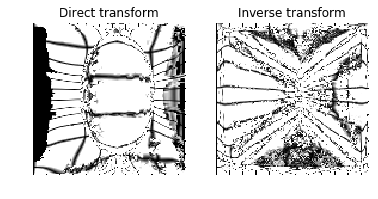

In [6]:
def register_dipy(img_static, img_moving, callback=None):
    sdr = SymmetricDiffeomorphicRegistration(metric=SSDMetric(img_static.ndim), 
                                             step_length=1., 
                                             level_iters=[50, 100], 
                                             inv_iter=50, 
                                             ss_sigma_factor=1.,
                                             opt_tol=1.e-3,
                                             callback=callback)
    
    t = time.time()
    mapping = sdr.optimize(img_static.astype(float), img_moving.astype(float))
    print ('optimize took:', time.time() - t)
    return mapping

mapping = register_dipy(img_static, img_static_fuzzy)
_= regtools.plot_2d_diffeomorphic_map(mapping, 10)

### Experiments

Register: **static <- moving** image

Creating scale space from the moving image. Levels: 2. Sigma factor: 1.000000.
Creating scale space from the static image. Levels: 2. Sigma factor: 1.000000.
Optimizing level 1


Optimizing level 0


('optimize took:', 0.6593570709228516)


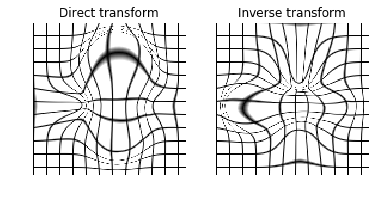

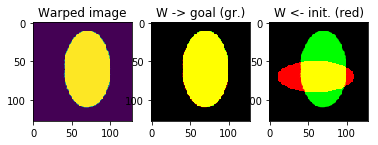

In [7]:
mapping = register_dipy(img_static, img_moving, None)
_= regtools.plot_2d_diffeomorphic_map(mapping, 10)
img_warped = mapping.transform(img_moving, 'linear')
nb_utils.show_registered_overlap(img_warped, img_static, img_moving)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f451b9cd350>,
 <matplotlib.image.AxesImage at 0x7f451b9468d0>)

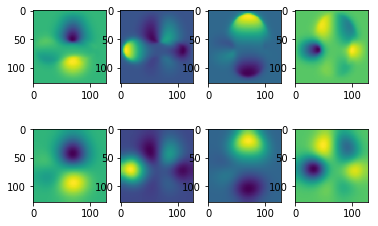

In [8]:
from scipy.ndimage.filters import gaussian_filter

plt.subplot(2, 4, 1), plt.imshow(mapping.forward[..., 0], interpolation='nearest')
plt.subplot(2, 4, 2), plt.imshow(mapping.forward[..., 1], interpolation='nearest')
plt.subplot(2, 4, 3), plt.imshow(mapping.backward[..., 0], interpolation='nearest')
plt.subplot(2, 4, 4), plt.imshow(mapping.backward[..., 1], interpolation='nearest')

m_sigma = [10, 10, 0]
mapping.forward = gaussian_filter(mapping.forward, sigma=m_sigma)
mapping.backward = gaussian_filter(mapping.backward, sigma=m_sigma)

plt.subplot(2, 4, 5), plt.imshow(mapping.forward[..., 0], interpolation='nearest')
plt.subplot(2, 4, 6), plt.imshow(mapping.forward[..., 1], interpolation='nearest')
plt.subplot(2, 4, 7), plt.imshow(mapping.backward[..., 0], interpolation='nearest')
plt.subplot(2, 4, 8), plt.imshow(mapping.backward[..., 1], interpolation='nearest')

Register: **static <- static FUZZY** image

Creating scale space from the moving image. Levels: 2. Sigma factor: 1.000000.
Creating scale space from the static image. Levels: 2. Sigma factor: 1.000000.
Optimizing level 1


Optimizing level 0


('optimize took:', 2.107191801071167)


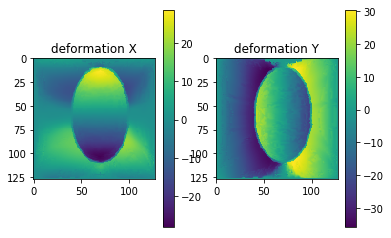

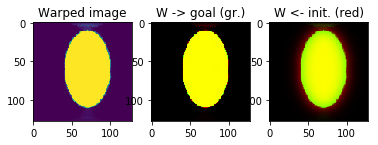

In [9]:
mapping = register_dipy(img_static.astype(float), img_static_fuzzy, None)
# _= regtools.plot_2d_diffeomorphic_map(mapping, 10)
nb_utils.show_registered_deformation(mapping.backward)
img_warped = mapping.transform(img_static_fuzzy, 'linear')
nb_utils.show_registered_overlap(img_warped, img_static, img_static_fuzzy)

Creating scale space from the moving image. Levels: 2. Sigma factor: 1.000000.
Creating scale space from the static image. Levels: 2. Sigma factor: 1.000000.
Optimizing level 1


Optimizing level 0


('optimize took:', 2.1672451496124268)


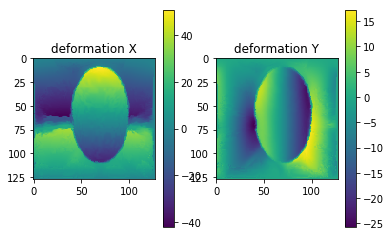

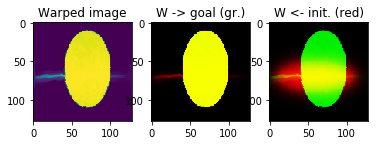

In [10]:
mapping = register_dipy(img_static, img_moving_fuzzy, None)
# _= regtools.plot_2d_diffeomorphic_map(mapping, 10)
nb_utils.show_registered_deformation(mapping.backward)
img_warped = mapping.transform(img_moving_fuzzy, 'linear')
nb_utils.show_registered_overlap(img_warped, img_static, img_moving_fuzzy)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f451b045510>,
 <matplotlib.image.AxesImage at 0x7f451af3ca90>)

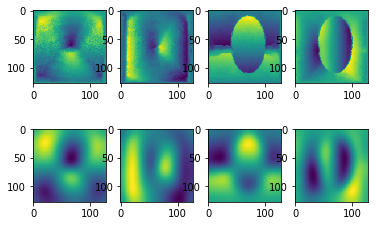

In [11]:
from scipy.ndimage.filters import gaussian_filter

plt.subplot(2, 4, 1), plt.imshow(mapping.forward[..., 0], interpolation='nearest')
plt.subplot(2, 4, 2), plt.imshow(mapping.forward[..., 1], interpolation='nearest')
plt.subplot(2, 4, 3), plt.imshow(mapping.backward[..., 0], interpolation='nearest')
plt.subplot(2, 4, 4), plt.imshow(mapping.backward[..., 1], interpolation='nearest')

m_sigma = [10, 10, 0]
mapping.forward = gaussian_filter(mapping.forward, sigma=m_sigma)
mapping.backward = gaussian_filter(mapping.backward, sigma=m_sigma)

plt.subplot(2, 4, 5), plt.imshow(mapping.forward[..., 0], interpolation='nearest')
plt.subplot(2, 4, 6), plt.imshow(mapping.forward[..., 1], interpolation='nearest')
plt.subplot(2, 4, 7), plt.imshow(mapping.backward[..., 0], interpolation='nearest')
plt.subplot(2, 4, 8), plt.imshow(mapping.backward[..., 1], interpolation='nearest')

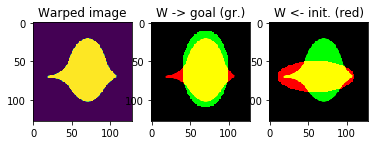

In [12]:
img_warped = mapping.transform(img_moving, 'linear')
nb_utils.show_registered_overlap(img_warped, img_static, img_moving)

## Smooth Symmetric Diffeomorphic Registration

In [13]:
from bpdl.registration import SmoothSymmetricDiffeomorphicRegistration
from dipy.align.imwarp import DiffeomorphicMap

def register_dipy_smooth(img_static, img_moving, smooth_sigma):
    sdr = SmoothSymmetricDiffeomorphicRegistration(metric=SSDMetric(img_static.ndim), 
                                                   smooth_sigma=smooth_sigma, 
                                                   step_length=1., 
                                                   level_iters=[5, 10], 
                                                   inv_iter=5, 
                                                   ss_sigma_factor=10.,
                                                   opt_tol=1.e-3)
    
    t = time.time()
    mapping = sdr.optimize(img_static.astype(float), img_moving.astype(float))
    print ('optimize took:', time.time() - t)

    # mapping_inv = sdr.moving_to_ref
    mapping_inv = DiffeomorphicMap(img_static.ndim,
                                   img_static.shape, None,
                                   img_static.shape, None,
                                   img_static.shape, None,
                                   None)
    mapping_inv.forward = np.array(sdr.moving_to_ref.forward)
    mapping_inv.backward = np.array(sdr.moving_to_ref.backward)
    return mapping, mapping_inv

Register: **static <- moving** image

Creating scale space from the moving image. Levels: 2. Sigma factor: 10.000000.
Creating scale space from the static image. Levels: 2. Sigma factor: 10.000000.
Optimizing level 1
Optimizing level 0


('optimize took:', 0.34917306900024414)


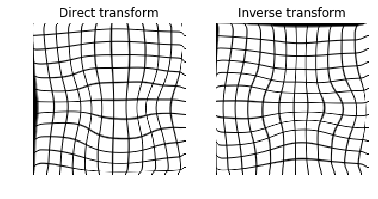

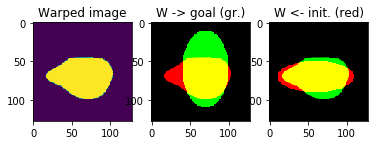

In [14]:
mapping, mapping_inv = register_dipy_smooth(img_static, img_moving, 10.)
_= regtools.plot_2d_diffeomorphic_map(mapping, 10)
img_warped = mapping.transform(img_moving, 'linear')
nb_utils.show_registered_overlap(img_warped, img_static, img_moving)

Register: **static <- static FUZZY** image

Creating scale space from the moving image. Levels: 2. Sigma factor: 10.000000.
Creating scale space from the static image. Levels: 2. Sigma factor: 10.000000.
Optimizing level 1
Optimizing level 0


('optimize took:', 0.3360099792480469)


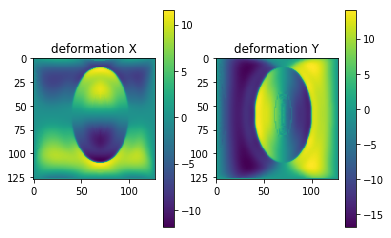

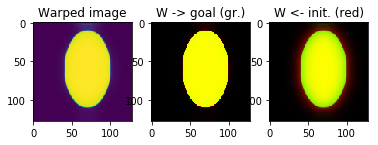

In [15]:
mapping, mapping_inv = register_dipy_smooth(img_static, img_static_fuzzy, 0.)

# _= regtools.plot_2d_diffeomorphic_map(mapping, 10)
nb_utils.show_registered_deformation(mapping.backward)
img_warped = mapping.transform(img_static_fuzzy, 'linear')
nb_utils.show_registered_overlap(img_warped, img_static, img_static_fuzzy)

('SSD input-target:', 446.38491288535107)
('SSD warped-target:', 39.534977233930519)


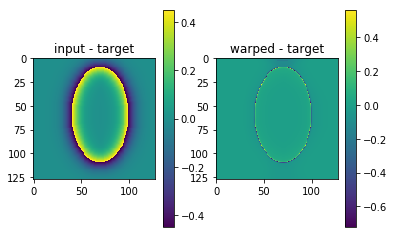

In [16]:
_= plt.subplot(121), plt.imshow(img_static - img_static_fuzzy), plt.title('input - target'), plt.colorbar()
print('SSD input-target:', np.sum((img_static - img_static_fuzzy) ** 2))
_= plt.subplot(122), plt.imshow(img_static - img_warped), plt.title('warped - target'), plt.colorbar()
print('SSD warped-target:', np.sum((img_static - img_warped) ** 2))

Invert transformation: **static -> static FUZZY** image

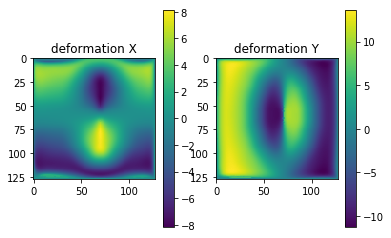

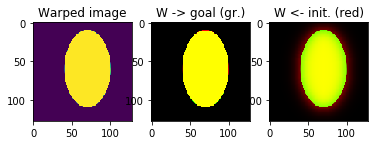

In [17]:
nb_utils.show_registered_deformation(mapping_inv.forward)
img_warped = mapping_inv.transform_inverse(img_static, 'linear')
nb_utils.show_registered_overlap(img_warped, img_static, img_static_fuzzy)

('SSD input-target:', 446.38491288535107)
('SSD warped-target:', 34.501153207744082)


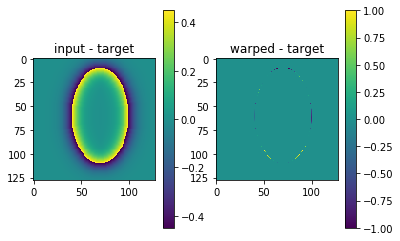

In [18]:
_= plt.subplot(121), plt.imshow(img_static - img_static_fuzzy), plt.title('input - target'), plt.colorbar()
print('SSD input-target:', np.sum((img_static - img_static_fuzzy) ** 2))
_= plt.subplot(122), plt.imshow(img_static - img_warped), plt.title('warped - target'), plt.colorbar()
print('SSD warped-target:', np.sum((img_static - img_warped) ** 2))

Register: **static <- moving FUZZY** image

Creating scale space from the moving image. Levels: 2. Sigma factor: 10.000000.
Creating scale space from the static image. Levels: 2. Sigma factor: 10.000000.
Optimizing level 1
Optimizing level 0


('optimize took:', 0.3405900001525879)


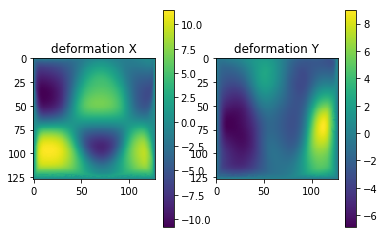

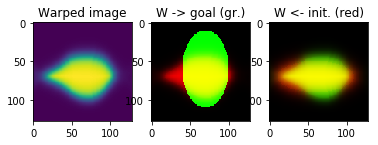

In [19]:
mapping, mapping_inv = register_dipy_smooth(img_static, img_moving_fuzzy, 10.)
# _= regtools.plot_2d_diffeomorphic_map(mapping, 10)
nb_utils.show_registered_deformation(mapping.backward)
img_warped = mapping.transform(img_moving_fuzzy, 'linear')
nb_utils.show_registered_overlap(img_warped, img_static, img_moving_fuzzy)

Invert transformation: **static -> moving FUZZY** image

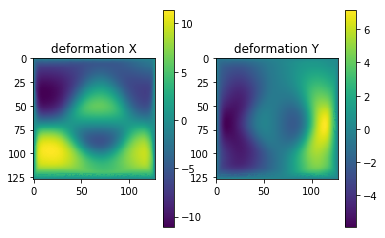

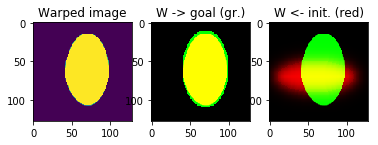

In [20]:
nb_utils.show_registered_deformation(mapping_inv.backward)
img_warped = mapping_inv.transform_inverse(img_static, 'linear')
nb_utils.show_registered_overlap(img_warped, img_static, img_moving_fuzzy)